In [23]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
def load_data(data_dir):
    '''
    Carrega os arquivos da pasta, separando as imagens e os labels correspondentes já codificados 
    '''
    # Lista para armazenar imagens e rótulos
    images = []
    labels = []
    
    # Loop sobre os arquivos no diretório
    for filename in os.listdir(data_dir):
        if filename.endswith('.png'):  # Supondo que suas imagens tenham extensão .jpg
            img = load_img(os.path.join(data_dir, filename), target_size=(300, 300))
            img_array = img_to_array(img)
            images.append(img_array)
            
            # Extrair rótulo do nome do arquivo
            label = filename.split(' ')[0]  # Pega o rótulo antes do espaço em branco
            labels.append(label)

    # Codificar rótulos em números
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    # Converter para array numpy
    images = np.array(images)
    labels = to_categorical(labels)

    return images, labels, label_encoder

In [25]:
def compute_class_weights(y_train):
    # Calcular pesos das classes baseados na distribuição dos dados
    class_weights = {}
    total_samples = len(y_train)
    num_classes = len(np.unique(np.argmax(y_train, axis=1)))
    for i in range(num_classes):
        class_count = np.sum(np.argmax(y_train, axis=1) == i)
        class_weights[i] = total_samples / (num_classes * class_count)

    return class_weights

In [26]:
def get_model(input_shape=(300,300,3), num_class=3):
    # Carregar o modelo VGG-16 pré-treinado
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Congelar as camadas do modelo base
    for layer in base_model.layers:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = Lambda(preprocess_input)(inputs)  # Aplicando a função preprocess_input como uma camada Lambda
    x = base_model(x, training=False)  # Modo de inferência para base_model
    # Adicionar camadas personalizadas
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs, predictions)
    
    # Compilar o modelo
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Apresenta um sumário do modelo
    model.summary()

    return model

In [27]:
# Diretório com suas imagens
data_dir = 'C:/Users/estela.ribeiro/JupyterNotebooks/side_job_breat_cancer/dataset/images/'

# Carregar os dados
images, labels, label_encoder = load_data(data_dir)

# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=42)

# Calcular pesos das classes
class_weights = compute_class_weights(y_train)

# Criar o modelo
input_shape = (300, 300, 3)
num_classes = 3  # Número de classes: benign, malign, normal
model = get_model(input_shape, num_classes)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 300, 300, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               10617088  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771   

In [28]:
# Treinar o modelo
model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), class_weight=class_weights)

Epoch 1/15
20/20 [==============================] - 619s 31s/step - loss: 14.6513 - accuracy: 0.5513 - val_loss: 3.7261 - val_accuracy: 0.7115
Epoch 2/15
20/20 [==============================] - 576s 29s/step - loss: 1.8520 - accuracy: 0.8173 - val_loss: 1.9030 - val_accuracy: 0.7179
Epoch 3/15
20/20 [==============================] - 578s 29s/step - loss: 0.4786 - accuracy: 0.8894 - val_loss: 0.6167 - val_accuracy: 0.8397
Epoch 4/15
20/20 [==============================] - 574s 29s/step - loss: 0.2932 - accuracy: 0.8990 - val_loss: 0.7494 - val_accuracy: 0.7564
Epoch 5/15
20/20 [==============================] - 576s 29s/step - loss: 0.2049 - accuracy: 0.9247 - val_loss: 0.6683 - val_accuracy: 0.8269
Epoch 6/15
20/20 [==============================] - 585s 30s/step - loss: 0.2825 - accuracy: 0.9519 - val_loss: 0.7330 - val_accuracy: 0.8141
Epoch 7/15
20/20 [==============================] - 577s 29s/step - loss: 0.1487 - accuracy: 0.9423 - val_loss: 0.7659 - val_accuracy: 0.8333
Epoch

In [29]:
# Avaliar o desempenho do modelo
loss, accuracy = model.evaluate(X_val, y_val)
print("Loss:", loss)
print("Accuracy:", accuracy)

5/5 [==============================] - 116s 23s/step - loss: 0.6801 - accuracy: 0.8526
Loss: 0.6801010966300964
Accuracy: 0.8525640964508057


In [30]:
# Fazer previsões no conjunto de validação
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

5/5 [==============================] - 116s 23s/step


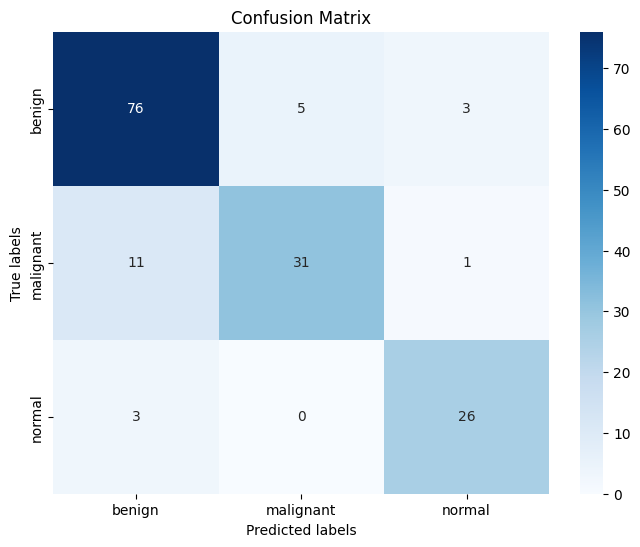

In [31]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

def classification_metrics_multiclass(y_true, y_pred, model, fold):
    '''
    Generate multiclass classification analysis
    '''
    
    # Confusion matrix for multiclass
    cm = confusion_matrix(y_true, y_pred)
    
    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_score_per_class = f1_score(y_true, y_pred, average=None)
    
    # Overall metrics
    accuracy = (cm.diagonal().sum()) / cm.sum()
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    
    try:
        auc_value = roc_auc_score(y_true, y_pred, multi_class='ovr')
    except ValueError:
        auc_value = None  # AUC calculation might fail if there's not enough variety in predictions
    
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return {
        "model": model, 
        "fold": fold,
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "precision_per_class": precision_per_class.tolist(), 
        "recall_per_class": recall_per_class.tolist(), 
        "f1_score_per_class": f1_score_per_class.tolist(),
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_score_macro": f1_score_macro,
        "auc": auc_value, 
        "kappa": kappa
    }

In [33]:
results = classification_metrics_multiclass(y_true, y_pred_classes, 'vgg16', '1')

In [34]:
results

{'model': 'vgg16',
 'fold': '1',
 'confusion_matrix': array([[76,  5,  3],
        [11, 31,  1],
        [ 3,  0, 26]], dtype=int64),
 'accuracy': 0.8525641025641025,
 'precision_per_class': [0.8444444444444444,
  0.8611111111111112,
  0.8666666666666667],
 'recall_per_class': [0.9047619047619048,
  0.7209302325581395,
  0.896551724137931],
 'f1_score_per_class': [0.8735632183908046,
  0.7848101265822784,
  0.8813559322033898],
 'precision_macro': 0.8574074074074075,
 'recall_macro': 0.8407479538193251,
 'f1_score_macro': 0.846576425725491,
 'auc': None,
 'kappa': 0.7501044713748433}